In [1]:
import sys
sys.path.append('/media/cjw/PythonLib/cjwdeeplearning')

import os
import numpy as np
import tensorflow as tf
import pandas as pd 

from matplotlib import pyplot as plt
from autoencoder import network
from autoencoder import utils

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
datadir =  '/media/cjw/Data/cyto/mmFromTifs3/'
#datadir =  '/media/cjw/Data/cyto/mmCompensatedTifs/'
cptop = '/media/cjw/Data/cyto/Checkpoints'
LS_dirs = [x for x in os.listdir(cptop) if 'LS' in x]

w = os.walk(cptop,  followlinks=True)

cps = dict()
working_on = '!@$2$@$@'
for r, d, f in w:
    if 'LS' in r and len(d) == 0:
        if len(f)==0:
            continue
        for c in f:
            if 'autoencoder' not in c:
                continue
            if working_on not in c:
                working_on = c.split('.')[0]
                #print('w', working_on, r)
                dsplit = working_on.split('-')
                vlen = int(dsplit[1][0:-1])
                inum = int(dsplit[-1])
                #print((vlen, inum))
                cps[(vlen, inum)] = r + "/" + working_on


In [3]:
def make_graph(cp_path, latent_size):
    tf.reset_default_graph()
                
    print(cp_path)
    if os.path.exists(cp_path + ".index"):
        print("OK, exists")
    else:
        print("Oh no")
        return None
    #checkpoint-2018-03-02-16-31-42/'
    p_width = 32
    p_height = 32
    p_nchannels = 4
    p_channels = [0,1,3,4]
    p_nepochs = 120
    p_batchsize = 128
    p_learning_rate = 0.0002  #.00005
    p_restore = False
    p_latent_size = latent_size
    p_droprate = 0.95
    p_stdev = .04

    enc_sizes = [(128, 3), (256, 3), (512, 3)] 
    #enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
    dec_sizes = list(reversed(enc_sizes))
    # enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
    # dec_sizes = list(reversed(enc_sizes))

    images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
    z = tf.placeholder(tf.float32, (None, p_latent_size))

    enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                          nfilters=enc_sizes)
    sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                          is_train=False, nfilters=dec_sizes)

    loss, _, _ = network.ae_loss(images, sdd)

    opt = network.model_opt(loss, p_learning_rate)

    saver = tf.train.Saver()

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    #saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
    saver.restore(sess, cp_path)
    return images, z, enc, sdd, loss, opt, sess


In [4]:
#### This is retrieving the images - so this happens regardless of the checkpoint


mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()
n_all_images = 0
for mmfilename in mmfiles:
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()
    

['/media/cjw/Data/cyto/mmFromTifs3/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_CCB.mm']
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
30000


dict_keys(['Fish6_Untreated.mm', 'Fish6_ICE.mm', 'Fish6_CCB.mm'])

In [5]:
#### Creating a dataframe for the info

n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=.4)
df = df.reset_index()
print(len(df))
df.tail()

10000
10000
10000
12000


,index,id,fid,file,mmfile,plate,row,column,field,yc,xc,well,treatment,run
11995,10940,10940,940,Fish6_ICE,Fish6_ICE.mm,0,0,0,0,32,32,0,ice,Fish6
11996,24662,24662,4662,Fish6_CCB,Fish6_CCB.mm,0,0,0,0,32,32,0,ccb,Fish6
11997,9494,9494,9494,Fish6_Untreated,Fish6_Untreated.mm,0,0,0,0,32,32,0,untreated,Fish6
11998,18732,18732,8732,Fish6_ICE,Fish6_ICE.mm,0,0,0,0,32,32,0,ice,Fish6
11999,6082,6082,6082,Fish6_Untreated,Fish6_Untreated.mm,0,0,0,0,32,32,0,untreated,Fish6


In [6]:
set([x[0] for x in cps.keys()])

{32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 512}

In [7]:
vv = utils.getWell(mmdict,
                        df, 32, 0, 0, 4, channels=[0,1,3,4])

ilist = np.random.randint(0,600, 36)
def run_space(latent_size, niter, cp_path):

    #latent_size = 256
    width = 32
    nchannels = 4

    #cp_path = cps[(latent_size, 27261)]

    images, z, enc, sdd, loss, opt, sess = make_graph(cp_path, latent_size)

    nvv = len(vv)
    offloc = 0
    offstep = 1000
    offnext = offloc + offstep
    xhe = np.zeros((nvv, latent_size))
    xdd = np.zeros((nvv, width, width, nchannels))
    while offloc < nvv:
        #print(offloc, offnext)
        xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
        xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
        offloc = offnext
        offnext += offstep
        if offnext > nvv:
            offnext = nvv

    decoded = xdd[ilist]
    xloss = sess.run(loss, feed_dict={images:vv, sdd:xdd})
    print(xhe.shape, xdd.shape, decoded.shape)
    print(np.amin(vv),np.amax(vv))
    return ({'latent_size':latent_size, 'niter':niter, 'loss':xloss}, decoded)

In [8]:
# xloss = sess.run(loss, feed_dict={images:vv, sdd:xdd})
# xloss


dimages = dict()
dlist = list()
#ddf.columns = ['latent_size', 'niter', 'loss']
for s, niter in cps.keys(): 
    #s, niter = list(cps.keys())[0]
    cp_path = cps[(s, niter)]
    print(s, niter, cp_path)
    d, decoded = run_space(s, niter, cp_path)
    dlist.append(d)
    dimages[(s, niter)] = decoded

ddf = pd.DataFrame(dlist)
ddf

96 27727 /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS96/checkpoint-2018-04-25-09-02-40/autoencoder-96x-27727
/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS96/checkpoint-2018-04-25-09-02-40/autoencoder-96x-27727
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
Tensor("latent_space/BiasAdd:0", shape=(?, 96), dtype=float32)
isize:  4 32
Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS96/checkpoint-2018-04-25-09-02-40/autoencoder-96x-27727
(12000, 96) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
96 27960 /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS96/checkpoint-2018-04-25-09-02-40/autoencoder-96x-27960
/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS96/checkpoint-2018-04-25-09-02-40/auto

Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-18-LS256/checkpoint-2018-04-18-16-56-46/autoencoder-256x-27960
(12000, 256) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
256 27727 /media/cjw/Data/cyto/Checkpoints/2018-04-18-LS256/checkpoint-2018-04-18-16-56-46/autoencoder-256x-27727
/media/cjw/Data/cyto/Checkpoints/2018-04-18-LS256/checkpoint-2018-04-18-16-56-46/autoencoder-256x-27727
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
Tensor("latent_space/BiasAdd:0", shape=(?, 256), dtype=float32)
isize:  4 32
Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
I

INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-26-LS352/checkpoint-2018-04-26-10-37-23/autoencoder-320x-27960
(12000, 320) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
320 27261 /media/cjw/Data/cyto/Checkpoints/2018-04-26-LS352/checkpoint-2018-04-26-10-37-23/autoencoder-320x-27261
/media/cjw/Data/cyto/Checkpoints/2018-04-26-LS352/checkpoint-2018-04-26-10-37-23/autoencoder-320x-27261
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
Tensor("latent_space/BiasAdd:0", shape=(?, 320), dtype=float32)
isize:  4 32
Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-26-LS352/checkpoint-2018-04-26-10-37-23/autoencoder-320x-27261
(12000, 320) (12000, 32, 32, 4) (36, 32,

(12000, 128) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
128 27960 /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS128/checkpoint-2018-04-25-10-43-45/autoencoder-128x-27960
/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS128/checkpoint-2018-04-25-10-43-45/autoencoder-128x-27960
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
Tensor("latent_space/BiasAdd:0", shape=(?, 128), dtype=float32)
isize:  4 32
Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS128/checkpoint-2018-04-25-10-43-45/autoencoder-128x-27960
(12000, 128) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
128 27261 /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS128/checkpoint-2018-04-25-10-43-45/autoenco

Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS192/checkpoint-2018-04-25-14-40-36/autoencoder-192x-27028
(12000, 192) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
192 27261 /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS192/checkpoint-2018-04-25-14-40-36/autoencoder-192x-27261
/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS192/checkpoint-2018-04-25-14-40-36/autoencoder-192x-27261
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
Tensor("latent_space/BiasAdd:0", shape=(?, 192), dtype=float32)
isize:  4 32
Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
I

INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS224/checkpoint-2018-04-25-16-07-09/autoencoder-224x-27494
(12000, 224) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
224 27727 /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS224/checkpoint-2018-04-25-16-07-09/autoencoder-224x-27727
/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS224/checkpoint-2018-04-25-16-07-09/autoencoder-224x-27727
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
Tensor("latent_space/BiasAdd:0", shape=(?, 224), dtype=float32)
isize:  4 32
Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS224/checkpoint-2018-04-25-16-07-09/autoencoder-224x-27727
(12000, 224) (12000, 32, 32, 4) (36, 32,

(12000, 64) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
64 27261 /media/cjw/Data/cyto/Checkpoints/2018-04-24-LS64/checkpoint-2018-04-24-12-20-19/autoencoder-64x-27261
/media/cjw/Data/cyto/Checkpoints/2018-04-24-LS64/checkpoint-2018-04-24-12-20-19/autoencoder-64x-27261
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
Tensor("latent_space/BiasAdd:0", shape=(?, 64), dtype=float32)
isize:  4 32
Tensor("Relu:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-24-LS64/checkpoint-2018-04-24-12-20-19/autoencoder-64x-27261
(12000, 64) (12000, 32, 32, 4) (36, 32, 32, 4)
0.05473199859261513 0.9829423427581787
64 27028 /media/cjw/Data/cyto/Checkpoints/2018-04-24-LS64/checkpoint-2018-04-24-12-20-19/autoencoder-64x-2702

,latent_size,loss,niter
0,96,NaN,27727
1,96,NaN,27960
2,96,NaN,27028
3,96,NaN,27261
4,96,NaN,27494
5,288,NaN,27727
6,288,NaN,27494
7,288,NaN,27028
8,288,NaN,27960
9,288,NaN,27261


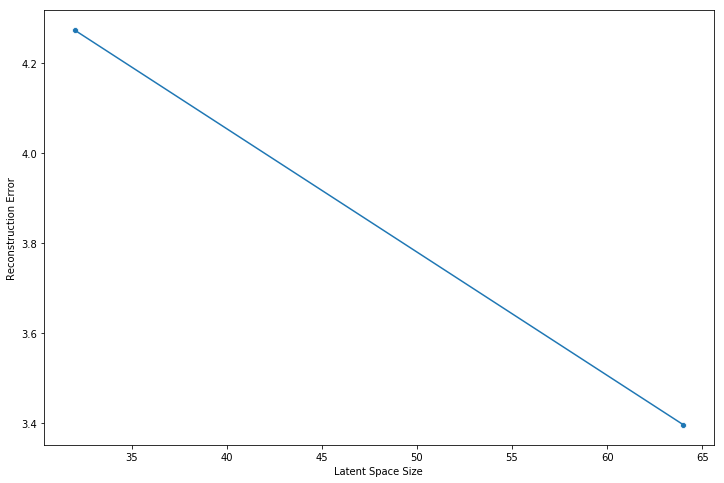

In [9]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(x='latent_size', y='loss', data=ddf[ddf['niter'] == 27261], ci=None, estimator=min)
sns.lineplot(x='latent_size', y='loss', data=ddf[ddf['niter'] == 27261], ci=None, estimator=min)
plt.xlabel('Latent Space Size')
plt.ylabel('Reconstruction Error')
plt.savefig('/media/cjw/latent_space.pdf')
plt.show()

In [153]:
ddf[ddf['niter'] == 2].to_csv('/media/cjw/latent_space.csv')

In [10]:
# ilist = np.random.randint(0,600, 6)

ilist, len(dimages)

(array([191, 596, 279,  51, 264, 184, 355,  81, 238, 553, 198,  21, 394,
        516, 286, 168, 448, 283, 534,   9, 226, 369,   6,  96, 173, 126,
        397,  88, 508, 345, 120,  28, 145, 164, 298, 400]), 65)

(36, 32, 32, 4) [191 596 279  51 264 184 355  81 238 553 198  21 394 516 286 168 448 283
 534   9 226 369   6  96 173 126 397  88 508 345 120  28 145 164 298 400]
Images 1 596
0032_27261.tif
0064_27261.tif
0096_27261.tif
0128_27261.tif
0160_27261.tif
0192_27261.tif
0224_27261.tif
0256_27261.tif
0288_27261.tif
0320_27261.tif
0352_27261.tif
0384_27261.tif
0512_27261.tif


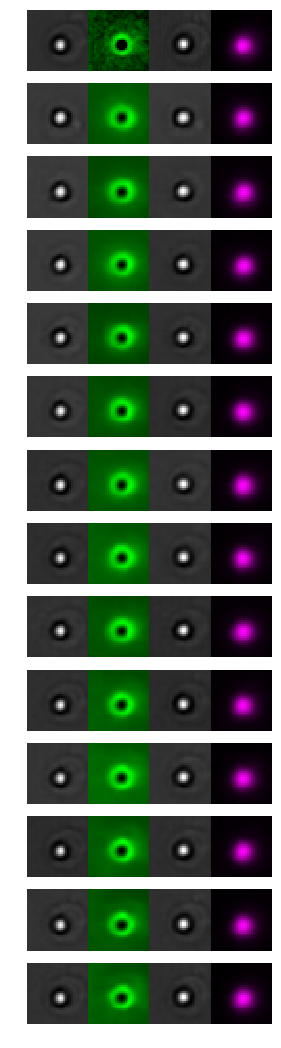

In [14]:
from matplotlib.colors import LinearSegmentedColormap

def normalize(x):
    xmin = x.min()
    xmax = x.max()
    x = 255*(x - xmin)/(xmax - xmin)
    return x.astype(np.int32)


g_cmap = LinearSegmentedColormap.from_list('bgreen', ['#000000', '#00ff00'])
m_cmap = LinearSegmentedColormap.from_list('bgreen', ['#000000', '#FF00FF'])
r_cmap = LinearSegmentedColormap.from_list('bgreen', ['#000000', '#00ff00'])
b_cmap = LinearSegmentedColormap.from_list('bgreen', ['#000000', '#0000ff'])
                  
orig = vv[ilist]
print(orig.shape, ilist)
keys = [x for x in dimages.keys() if x[1] == 27261]
psi = 1
plt.figure(figsize=(10,20))

ni = 1  # did 7 already
o = orig[ni]
print("Images", ni, ilist[ni])
row = np.zeros((32,32*4, 3), dtype=np.int32)
row[:, 0:32, 0] = normalize(o[:,:,0])
row[:, 0:32, 1] = normalize(o[:,:,0])
row[:, 0:32, 2] = normalize(o[:,:,0])
row[:, 32:64, 1] = normalize(o[:,:,1])
row[:, 64:96, 0] = normalize(o[:,:,2])
row[:, 64:96, 1] = normalize(o[:,:,2])
row[:, 64:96, 2] = normalize(o[:,:,2])
row[:, 96:128, 0] = normalize(o[:,:,3])
row[:, 96:128, 2] = normalize(o[:,:,3])
plt.subplot(15, 1, psi)
plt.imshow(row, cmap='gray')
plt.axis('off')
psi += 1

for k in sorted(keys):
#     print(k)
    z = dimages[k][ni]
    o = orig[ni]
#     print(z.shape)
    
    row = np.zeros((32,32*4, 3), dtype=np.int32)
    title = str(k[0]).zfill(4) + "_" + str(k[1]) + ".tif"
    print(title)

    c1 = normalize(z[:,:,0])
    t1 = str(ni).zfill(3) + "_" + str(k[0]).zfill(4) + "_" + str(k[1]) + "_c1.tif"
    c2 = normalize(z[:,:,1])
    t2 = str(ni).zfill(3) + "_" + str(k[0]).zfill(4) + "_" + str(k[1]) + "_c2.tif"
    c3 = normalize(z[:,:,2])
    t3 = str(ni).zfill(3) + "_" + str(k[0]).zfill(4) + "_" + str(k[1]) + "_c3.tif"
    c4 = normalize(z[:,:,3])
    t4 = str(ni).zfill(3) + "_" + str(k[0]).zfill(4) + "_" + str(k[1]) + "_c4.tif"
    
    idir = '/media/cjw/ls_images/'
    plt.imsave(idir + t1, c1, cmap='gray')
    plt.imsave(idir + t2, c2, cmap='gray')
    plt.imsave(idir + t3, c3, cmap='gray')
    plt.imsave(idir + t4, c4, cmap='gray')
    
    row[:, 0:32, 0] = normalize(z[:,:,0])
    row[:, 0:32, 1] = normalize(z[:,:,0])
    row[:, 0:32, 2] = normalize(z[:,:,0])
    
    row[:, 32:64, 1] = normalize(z[:,:,1])
#     row[:, 32:64, 2] = normalize(z[:,:,1])
    
    row[:, 64:96, 0] = normalize(z[:,:,2])
    row[:, 64:96, 1] = normalize(z[:,:,2])
    row[:, 64:96, 2] = normalize(z[:,:,2])
    
    row[:, 96:128, 0] = normalize(z[:,:,3])
    row[:, 96:128, 2] = normalize(z[:,:,3])
    plt.subplot(15, 1, psi)
    plt.imshow(row, cmap=m_cmap)
    plt.axis('off')
    psi += 1
plt.show()

[0.77626085 0.44608939 0.79162323 0.41589439]
(32, 32, 4)


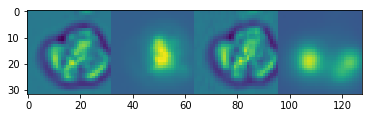

[-2.77273048 -0.67142739 -2.65049741 -0.90253716]


In [188]:
x1 = orig[3]
print(np.max(x1, axis=(0, 1)))
print(x1.shape)

xn = x1 - x1.mean(axis=(0,1))
xs = xn.std(axis=(0,1))
xns = xn/xs

orow = np.zeros((32,32*4), dtype=np.float32)

orow[:, 0:32] = xns[:,:,0]
orow[:, 32:64] = xns[:,:,1]
orow[:, 64:96] = xns[:,:,2]
orow[:, 96:128] = xns[:,:,3]

plt.imshow(orow)
plt.show()

print(xns.min(axis=(0,1)))

2314
796
3160
4777
4178
3609


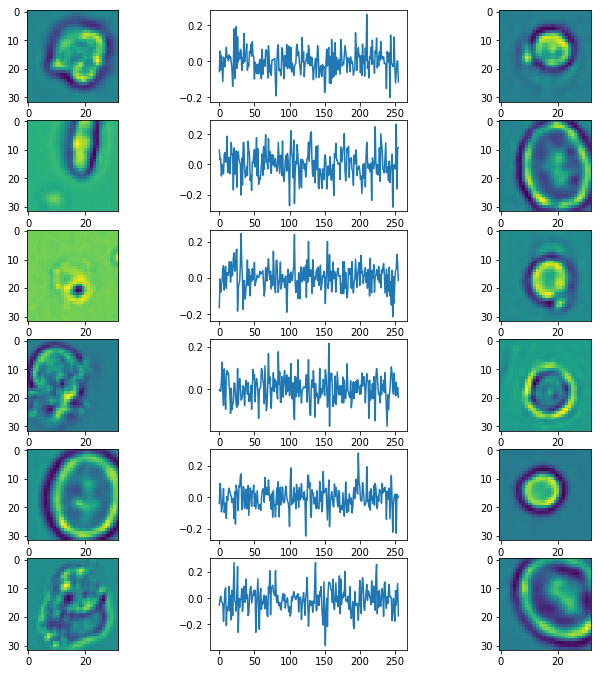

In [140]:
f = plt.figure(figsize=(12, 40))
ilist = [2314, 796, 3160, 4777, 4178, 3609]
for i, ix in enumerate(ilist):
    #ix = i #np.random.randint(0, len(vv))
    #ilist.append(ix)
    print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0])
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0])
   
plt.show()

In [26]:
ix

1189